# Thyroid Dataset

## Class:

1.   Normal
2.   Hyperthyroidism
3.   Hypothyroidism


### Installing Libraries

In [ ]:
#libraries import
!pip install -U imbalanced-learn
!pip install mlxtend
!pip install ggplot
from ggplot import *
from imblearn.over_sampling import SMOTE 
import numpy as np
from sklearn.model_selection import train_test_split 
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from imblearn.over_sampling import RandomOverSampler

np.set_printoptions(suppress=True)

In [ ]:
# Select from your local file system:
from google.colab import files
uploaded = files.upload()

In [ ]:
column_names = ['age','sex', 'on_thyroxine', 'query_on_thyroxine', 'antithyroid_medication', 'sick', 'pregnant',
                'thyroid_surgery', 'i131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
                'goitre', 'tumor', 'hypopituitary', 'psych', 'tsh', 't3', 'tt4', 't4u', 'fti', 'class']

### Reading Dataset

In [ ]:
# Open uploaded dataset
import pandas as pd
import io
train = pd.read_csv(io.StringIO(uploaded['train.csv'].decode('utf-8')), names=column_names, sep=' ')
test = pd.read_csv(io.StringIO(uploaded['test.csv'].decode('utf-8')), names=column_names, sep=' ')


In [ ]:
X_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]
X_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1]
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (3772, 21)
y_train:  (3772,)
X_test:  (3428, 21)
y_test:  (3428,)


In [ ]:
# Splitting datasets into majority and minority class

class_1 = train.loc[train['class'] == 1]
class_2 = train.loc[train['class'] == 2]
class_3 = train.loc[train['class'] == 3]

In [ ]:
print('class 1: ', class_1.shape[0])
print('class 2: ', class_2.shape[0])
print('class 3: ', class_3.shape[0])

class 1:  93
class 2:  191
class 3:  3488


Hormones ranges per class

In [ ]:
print('T3 RANGES')
print('1: ', class_1['t3'].min(), '  -  ', class_1['t3'].max())
print('2: ', class_2['t3'].min(), '  -  ', class_2['t3'].max())
print('3: ', class_3['t3'].min(), '  -  ', class_3['t3'].max())

print('\nTT4 RANGES')
print('1: ', class_1['tt4'].min(), '  -  ', class_1['tt4'].max())
print('2: ', class_2['tt4'].min(), '  -  ', class_2['tt4'].max())
print('3: ', class_3['tt4'].min(), '  -  ', class_3['tt4'].max())

print('\nT4U RANGES')
print('1: ', class_1['t4u'].min(), '  -  ', class_1['t4u'].max())
print('2: ', class_2['t4u'].min(), '  -  ', class_2['t4u'].max())
print('3: ', class_3['t4u'].min(), '  -  ', class_3['t4u'].max())

print('\nTSH RANGES')
print('1: ', class_1['tsh'].min(), '  -  ', class_1['tsh'].max())
print('2: ', class_2['tsh'].min(), '  -  ', class_2['tsh'].max())
print('3: ', class_3['tsh'].min(), '  -  ', class_3['tsh'].max())

print('\nFTI RANGES')
print('1: ', class_1['fti'].min(), '  -  ', class_1['fti'].max())
print('2: ', class_2['fti'].min(), '  -  ', class_2['fti'].max())
print('3: ', class_3['fti'].min(), '  -  ', class_3['fti'].max())

T3 RANGES
1:  0.002   -   0.026000000000000002
2:  0.003   -   0.040999999999999995
3:  0.0005   -   0.1059

TT4 RANGES
1:  0.002   -   0.08900000000000001
2:  0.044000000000000004   -   0.14800000000000002
3:  0.019   -   0.43

T4U RANGES
1:  0.061   -   0.15
2:  0.055999999999999994   -   0.165
3:  0.019   -   0.23199999999999998

TSH RANGES
1:  0.0062   -   0.53
2:  0.0061   -   0.14300000000000002
3:  0.0   -   0.145

FTI RANGES
1:  0.002   -   0.064
2:  0.06493   -   0.153
3:  0.017   -   0.612



We can see that the ranges of the majority class overlaps the minority ranges, the classification will prefer the majority class.

### Covariance Matrix

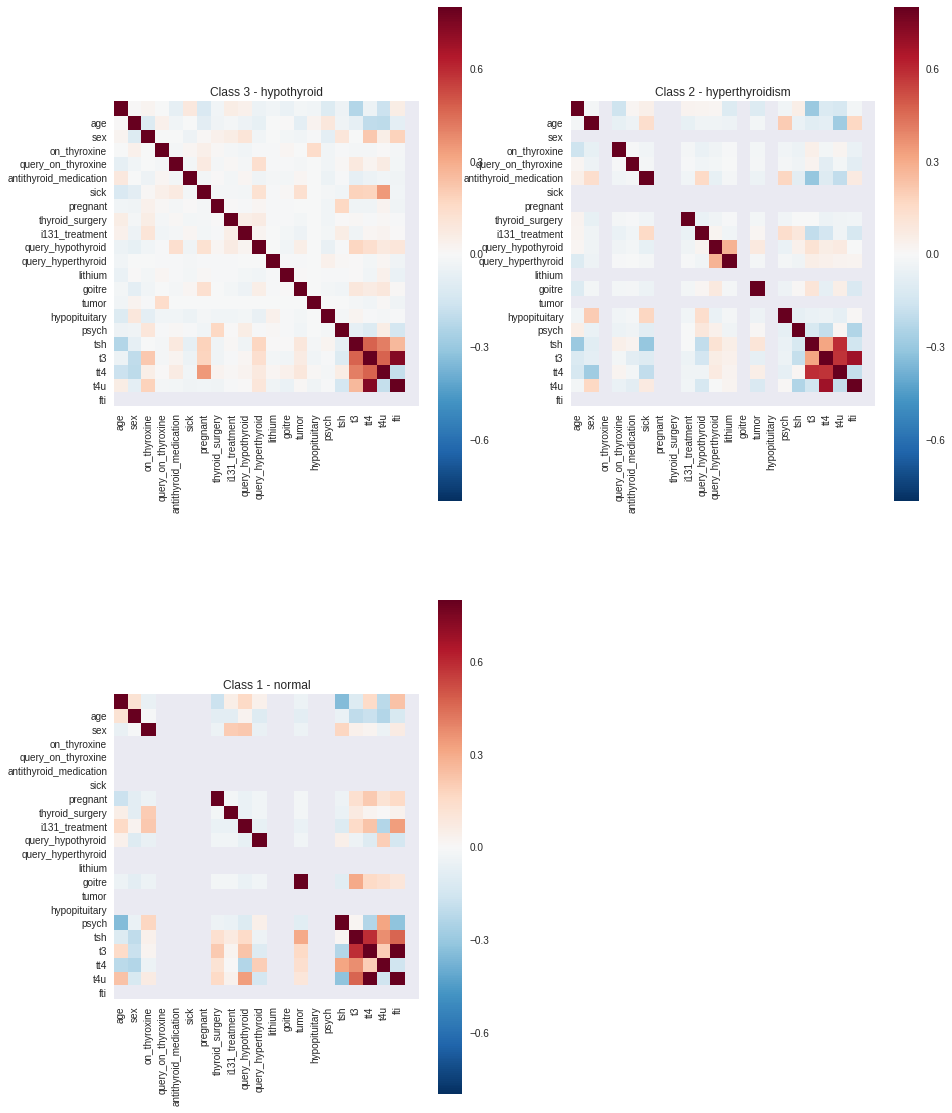

In [ ]:
# plot covariance matrix for each class


plt.figure(figsize=(15,20))
plt.subplot(2,2,1)
tt = pd.DataFrame.from_records(class_3)
corrmat = tt.corr()
sns.plt.title('Class 3 - hypothyroid')
sns.heatmap(corrmat, yticklabels=column_names[:-1], xticklabels=column_names[:-1], vmax=.8, square=True);

plt.subplot(2,2,2)
tt = pd.DataFrame.from_records(class_2)
corrmat = tt.corr()
sns.plt.title('Class 2 - hyperthyroidism')
sns.heatmap(corrmat, yticklabels=column_names[:-1], xticklabels=column_names[:-1], vmax=.8, square=True);

plt.subplot(2,2,3)
tt = pd.DataFrame.from_records(class_1)
corrmat = tt.corr()
sns.plt.title('Class 1 - normal')
sns.heatmap(corrmat, yticklabels=column_names[:-1], xticklabels=column_names[:-1], vmax=.8, square=True);



We can see there is significative correlation between
t3 - fti,
t3 - tt4,
t4u - tt4,
t4u - tsh,
tsh - tt4


### Plotting confusion matrix


In [ ]:
def confusion_matrix_heatmap(y_test, y_pred):
  confusion_mc = confusion_matrix(y_test, y_pred)
  df_cm = pd.DataFrame(confusion_mc)
  plt.figure(figsize=(5.5,4))
  sns.heatmap(df_cm, annot=True, fmt='g')
  plt.title('Accuracy: {0:.3f}'.format(accuracy_score(y_test, y_pred)))
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

### Print variance of variables

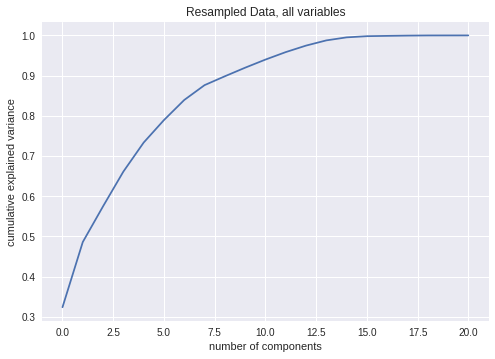

In [ ]:
# Explore variance of the variables
pca = PCA()
pca.fit_transform(X_train)

#print variance of features
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Resampled Data, all variables')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

We observe that still can conserve about 90% of the variance of the train dataset by keeping 10 features

**Plot PCA to view clusters**

We can see that class 2 (Hyperthyroidism) is an inlier class and there are 4 clearly separated clusters

In [ ]:
pca_result = PCA()
pca_result = pca_result.fit_transform(X_train, y_train)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1]
df['pca-three'] = pca_result[:,2]
chart = ggplot(df, aes(x='pca-one', y='pca-two', color='class') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by class")
chart

##Feature selection Techniques:

---



## Apply PCA 95% variance

In [ ]:
#reduce dimensionality retaining 95% of variance
pca = PCA(.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("Number of variables:", pca.n_components_)
print(pca.explained_variance_ratio_) 

Number of variables: 12
[0.32368947 0.16219123 0.08894782 0.08628097 0.07222764 0.05601449
 0.0499651  0.0368962  0.02207647 0.02135181 0.02018422 0.01859662]


By applying PCA, we conserve 95% of variance in the dataset keeping 12 attibutes.


## Step forward selection SFS

http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.655.363&rep=rep1&type=pdf

In [ ]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf')
# Build step forward feature selection with a SVM radial basis kernel
sfs1 = sfs(clf,
           k_features=12,
           forward=True,
           floating=False,
           #verbose=2,
           scoring='accuracy',
           cv=10)

# Perform SFFS
sfs1 = sfs1.fit(X_train, y_train)



In [ ]:
# Which features?
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 16, 18, 20]


In [ ]:
# Reduction of training and test set features

X_train_sfs = X_train.iloc[:, feat_cols]
X_test_sfs = X_test.iloc[:, feat_cols]

In [ ]:
print("Attributes: ", X_train_sfs.columns)

Attributes:  Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery',
       'i131_treatment', 'tsh', 'tt4', 'fti'],
      dtype='object')


##Resampling Techniques:

---



## Over Sampling

#### Using PCA

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_oversampling_pca, y_train_oversampling_pca = ros.fit_resample(X_train_pca, y_train)
print("Resampled dataset shape: ", sorted(Counter(y_train_oversampling_pca).items()))

Resampled dataset shape:  [(1, 3488), (2, 3488), (3, 3488)]


#### Using SFS

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_oversampling_sfs, y_train_oversampling_sfs = ros.fit_resample(X_train_sfs, y_train)
print("Resampled dataset shape: ", sorted(Counter(y_train_oversampling_sfs).items()))

Resampled dataset shape:  [(1, 3488), (2, 3488), (3, 3488)]


#### Using all attributes FULL

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_oversampling_full, y_train_oversampling_full = ros.fit_resample(X_train, y_train)
print("Resampled dataset shape: ", sorted(Counter(y_train_oversampling_full).items()))

Resampled dataset shape:  [(1, 3488), (2, 3488), (3, 3488)]


## SMOTE

### Using PCA

In [ ]:
sm = SMOTE(random_state=42)
X_train_smote_pca, y_train_smote_pca = sm.fit_sample(X_train_pca, y_train)
print('Resampled dataset shape:', Counter(y_train_smote_pca))

Resampled dataset shape: Counter({3: 3488, 2: 3488, 1: 3488})


### Using SFS

In [ ]:
sm = SMOTE(random_state=42)
X_train_smote_sfs, y_train_smote_sfs = sm.fit_sample(X_train_sfs, y_train)
print('Resampled dataset shape:', Counter(y_train_smote_sfs))

Resampled dataset shape: Counter({3: 3488, 2: 3488, 1: 3488})


### Using all attributes FULL

In [ ]:
sm = SMOTE(random_state=42)
X_train_smote_full, y_train_smote_full = sm.fit_sample(X_train, y_train)
print('Resampled dataset shape:', Counter(y_train_smote_full))

Resampled dataset shape: Counter({3: 3488, 2: 3488, 1: 3488})


## SCUT SMOTE and Clustered undersampling Technique

#### Algoritm:
- Split dataset (training set) into majority and minority class
- Calculate media of all data points
- For all classes that have a number of instances less than the total mean, oversampling the subset with SMOTE 
- For all classes that have a number of instances higher than the total mean, apply gausian mixture using em to find clusters
  - if no clusters are found in the subset, then apply random selection

https://nrc-publications.canada.ca/eng/view/fulltext/?id=e8c7556d-9f94-466f-a1e5-72cdf9b9513f

###Using PCA

In [ ]:
# Splitting training set into majority and minority class
class_3_pca = X_train_pca[y_train == 3, :]
class_2_pca = X_train_pca[y_train == 2, :]
class_1_pca = X_train_pca[y_train == 1, :]

print('class 1: ', class_1_pca.shape[0])
print('class 2: ', class_2_pca.shape[0])
print('class 3: ', class_3_pca.shape[0])

class 1:  93
class 2:  191
class 3:  3488


In [ ]:
# Calculating media from classes
m = int((class_1_pca.shape[0] + class_2_pca.shape[0] + class_3_pca.shape[0]) / 3)
print("Media: ", m)

Media:  1257


We see that the class 1 and class 2 are under the media, so we will apply SMOTE for their subsets. Class 3 is over the media, so we will apply clustering and undersampling

We apply SMOTE for minority classes

In [ ]:
# group minority clases for SMOTE
minority_classes_pca = np.append(X_train_pca, np.expand_dims(y_train, axis=1), axis=1)
minority_classes_pca = minority_classes_pca[minority_classes_pca[:, -1]!=3]

#subset into x,y
minority_x_pca = minority_classes_pca[:, :-1]
minority_y_pca = minority_classes_pca[:, -1]

In [ ]:
#applying SMOTE to minority classes
sm = SMOTE(random_state=42, sampling_strategy={2:m, 1:m})
X_minority_resampled_pca, y_minority_resampled_pca = sm.fit_sample(minority_x_pca, minority_y_pca)

print('Original dataset shape:', Counter(y_train))
print('Resampled dataset shape:', Counter(y_minority_resampled_pca))

Original dataset shape: Counter({3: 3488, 2: 191, 1: 93})
Resampled dataset shape: Counter({2.0: 1257, 1.0: 1257})


/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (1257) in class 2 will be larger than the number of samples in the majority class (class #2.0 -> 191)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (1257) in class 1 will be larger than the number of samples in the majority class (class #2.0 -> 191)
  n_samples_majority))


We now take care of majority class: 
we first cluster the subset using Gaussian Mixture and EM.   
If no clusters are found, then we random select 

Text(0.5, 1.0, 'Relationship between Second and Third PCA component')

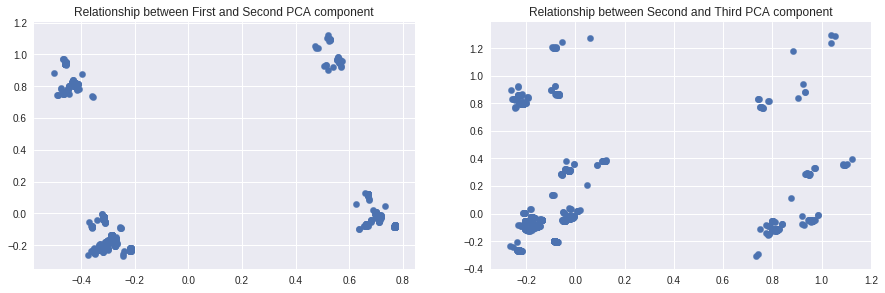

In [ ]:
# If there are no clusters, we random select, if there are clusters, then we also random select but within each cluster
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3).fit(class_3_pca)
#plt.scatter(class_3[:, 8], class_3[:, 0], s=40, cmap='viridis');

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.scatter(class_3_pca[:, 0], class_3_pca[:, 1], s=40, cmap='viridis');
plt.title('Relationship between First and Second PCA component')
plt.subplot(2,2,2)
plt.scatter(class_3_pca[:, 1], class_3_pca[:, 2], s=40, cmap='viridis');
plt.title('Relationship between Second and Third PCA component')


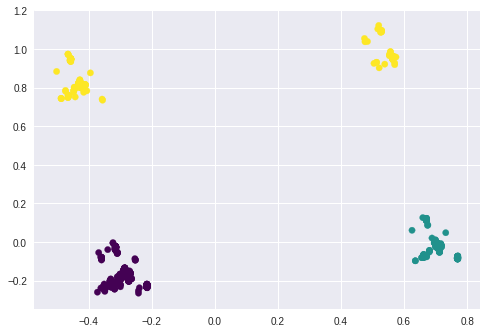

In [ ]:
# Plot the data with K Means to check if we get the same number of clusters we obtained with Gaussian Mixture
from sklearn.cluster import KMeans
kmeans = KMeans(3, random_state=0)
labels = kmeans.fit(class_3_pca).predict(class_3_pca)
plt.scatter(class_3_pca[:, 0], class_3_pca[:, 1], c=labels, s=40, cmap='viridis');

In [ ]:
# This was just to test if the size of the kmeans clusters were similar to the ones found by Gaussian Mixture model.
# Below is the distribution, very close to soft clusters.
'''
Examples within cluster 1:  1875
Examples within cluster 2:  1029
Examples within cluster 3:  217
Examples within cluster 4:  367
'''

'''kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(class_3_pca).predict(class_3_pca)

majority_cluster_1_pca = []
majority_cluster_2_pca = []
majority_cluster_3_pca = []
majority_cluster_4_pca = []
#{i: X[np.where(estimator.labels_ == i)] for i in range(estimator.n_clusters)}
for i in range(0,class_3_pca.shape[0]):
  if kmeans.labels_[i] == 0:
    majority_cluster_1_pca.append(class_3_pca[i])
  elif kmeans.labels_[i] == 1:
    majority_cluster_2_pca.append(class_3_pca[i])
  elif kmeans.labels_[i] == 2:
    majority_cluster_3_pca.append(class_3_pca[i])
  elif kmeans.labels_[i] == 3:
    majority_cluster_4_pca.append(class_3_pca[i])
    
majority_cluster_1_pca = np.array(majority_cluster_1_pca)
majority_cluster_2_pca = np.array(majority_cluster_2_pca)
majority_cluster_3_pca = np.array(majority_cluster_3_pca)
majority_cluster_4_pca = np.array(majority_cluster_4_pca)
print("Examples within cluster 1: ", majority_cluster_1_pca.shape[0])
print("Examples within cluster 2: ", majority_cluster_2_pca.shape[0])
print("Examples within cluster 3: ", majority_cluster_3_pca.shape[0])
print("Examples within cluster 4: ", majority_cluster_4_pca.shape[0])'''

We can see that there are clearly 4 clusters within the majority class, the same as given by Gaussian Mixture model

We then separate the data according to the 4 clusters found withing the majority class

In [ ]:
# Separate examples per cluster of Gaussian Mixture model
gmm = GaussianMixture(n_components=4).fit(class_3_pca)
probs = gmm.predict_proba(class_3_pca)

majority_cluster_1_pca = []
majority_cluster_2_pca = []
majority_cluster_3_pca = []
majority_cluster_4_pca = []

# Assign example to a cluster if the probability of belonging to that cluster is greater than 50%
for i in range(0, probs.shape[0]):
  if probs[i][0] > 0.5:
    majority_cluster_1_pca.append(class_3_pca[i])
  elif probs[i][1] > 0.5:
    majority_cluster_2_pca.append(class_3_pca[i])
  elif probs[i][2] > 0.5:
    majority_cluster_3_pca.append(class_3_pca[i])
  elif probs[i][3] > 0.5:
    majority_cluster_4_pca.append(class_3_pca[i])

majority_cluster_1_pca = np.array(majority_cluster_1_pca)
majority_cluster_2_pca = np.array(majority_cluster_2_pca)
majority_cluster_3_pca = np.array(majority_cluster_3_pca)
majority_cluster_4_pca = np.array(majority_cluster_4_pca)
print("Examples within cluster 1: ", majority_cluster_1_pca.shape[0])
print("Examples within cluster 2: ", majority_cluster_2_pca.shape[0])
print("Examples within cluster 3: ", majority_cluster_3_pca.shape[0])
print("Examples within cluster 4: ", majority_cluster_4_pca.shape[0])
print("Total: ", (majority_cluster_1_pca.shape[0] + majority_cluster_2_pca.shape[0] + majority_cluster_3_pca.shape[0] + majority_cluster_4_pca.shape[0]))

Examples within cluster 1:  1631
Examples within cluster 2:  996
Examples within cluster 3:  405
Examples within cluster 4:  456
Total:  3488


From the total of 4,451 examples from class 3, we have to undersampling to 1257 (media). 
We will choose the examples withing each of the 4 clusters found randomly and proportional to the size of each cluster.

- for cluster 1: 
  2325/4451 = 0.52  => 0.52*1608 = 840 
- for cluster 2:
  1220/4451 = 0.27  => 0.27*1608 = 441
- for cluster 3:
  309/4451 = 0.07   => 0.07*1608 = 111
- for cluster 4:
  597/4451 = 0.13   => 0.13*1608 = 216

In [ ]:
size_cluster_1_pca = int((majority_cluster_1_pca.shape[0]/class_3_pca.shape[0]) * m)
size_cluster_2_pca = int((majority_cluster_2_pca.shape[0]/class_3_pca.shape[0]) * m)
size_cluster_3_pca = int((majority_cluster_3_pca.shape[0]/class_3_pca.shape[0]) * m)
size_cluster_4_pca = int((majority_cluster_4_pca.shape[0]/class_3_pca.shape[0]) * m)
print("Size of cluster 1: ", size_cluster_1_pca)
print("Size of cluster 2: ", size_cluster_2_pca)
print("Size of cluster 3: ", size_cluster_3_pca)
print("Size of cluster 4: ", size_cluster_4_pca)
print("Total: ", (size_cluster_1_pca + size_cluster_2_pca + size_cluster_3_pca + size_cluster_4_pca))

Size of cluster 1:  587
Size of cluster 2:  358
Size of cluster 3:  145
Size of cluster 4:  164
Total:  1254


In [ ]:
# Proportionally random undersampling from each cluster withing majority class
majority_cluster_1_pca_us = majority_cluster_1_pca[np.random.choice(majority_cluster_1_pca.shape[0], size_cluster_1_pca)]
majority_cluster_2_pca_us = majority_cluster_2_pca[np.random.choice(majority_cluster_2_pca.shape[0], size_cluster_2_pca)]
majority_cluster_3_pca_us = majority_cluster_3_pca[np.random.choice(majority_cluster_3_pca.shape[0], size_cluster_3_pca)]
majority_cluster_4_pca_us = majority_cluster_4_pca[np.random.choice(majority_cluster_4_pca.shape[0], size_cluster_4_pca)]


In [ ]:
# Group all clusters from within majority class into singe array

X_majority_resampled_pca = np.concatenate((majority_cluster_1_pca_us, majority_cluster_2_pca_us, majority_cluster_3_pca_us, majority_cluster_4_pca_us))
print(X_majority_resampled_pca.shape)

# Create corresponding label array
y_majority_resampled_pca = np.full((1254,), 3)

(1254, 12)


Now that we have oversampled minority classes and undersampling majority class, we merge the subsets into one new balanced dataset

In [ ]:
# Merge minority and majority class subsets

X_train_scut_pca = np.append(X_minority_resampled_pca, X_majority_resampled_pca, axis=0)
y_train_scut_pca = np.append(y_minority_resampled_pca, y_majority_resampled_pca, axis=0)
print(X_train_scut_pca.shape)
print(y_train_scut_pca.shape)

(3768, 12)
(3768,)


In [ ]:
# Checking class balance

pd.Series(y_train_scut_pca).value_counts()

1.0    1257
2.0    1257
3.0    1254
dtype: int64

###Using SFS

In [ ]:
# Splitting training set into majority and minority class

y_train_sfs = y_train.to_frame()
ix = (y_train_sfs.loc[y_train_sfs['class'] == 1]).index.values
class_1_sfs = X_train_sfs.loc[ix,:]
ix = (y_train_sfs.loc[y_train_sfs['class'] == 2]).index.values
class_2_sfs = X_train_sfs.loc[ix,:]
ix = (y_train_sfs.loc[y_train_sfs['class'] == 3]).index.values
class_3_sfs = X_train_sfs.loc[ix,:]

print("class 1: ", class_1_sfs.shape[0])
print("class 2: ", class_2_sfs.shape[0])
print("class 3: ", class_3_sfs.shape[0])
print("Total: ", (class_1_sfs.shape[0] + class_2_sfs.shape[0] + class_3_sfs.shape[0]))

class 1:  93
class 2:  191
class 3:  3488
Total:  3772


In [ ]:
# Calculating media from classes
m = int((class_1_sfs.shape[0] + class_2_sfs.shape[0] + class_3_sfs.shape[0]) / 3)
print("Media: ", m)

Media:  1257


We see that the class 1 and class 2 are under the media, so we will apply SMOTE for their subsets. Class 3 is over the media, so we will apply clustering and undersampling

We apply SMOTE for minority classes

In [ ]:
# group minority clases for SMOTE
minority_classes_sfs = np.append(X_train_sfs, np.expand_dims(y_train, axis=1), axis=1)
minority_classes_sfs = minority_classes_sfs[minority_classes_sfs[:, -1]!=3]

#subset into x,y
minority_x_sfs = minority_classes_sfs[:, :-1]
minority_y_sfs = minority_classes_sfs[:, -1]

In [ ]:
#applying SMOTE to minority classes
sm = SMOTE(random_state=42, sampling_strategy={2:m, 1:m})
X_minority_resampled_sfs, y_minority_resampled_sfs = sm.fit_sample(minority_x_sfs, minority_y_sfs)

print('Original dataset shape:', Counter(y_train))
print('Resampled dataset shape:', Counter(y_minority_resampled_sfs))

Original dataset shape: Counter({3: 3488, 2: 191, 1: 93})
Resampled dataset shape: Counter({2.0: 1257, 1.0: 1257})


/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (1257) in class 2 will be larger than the number of samples in the majority class (class #2.0 -> 191)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (1257) in class 1 will be larger than the number of samples in the majority class (class #2.0 -> 191)
  n_samples_majority))


We now take care of majority class: 
we first cluster the subset using Gaussian Mixture and EM.   
If no clusters are found, then we random select. If more than one cluster is found, then we random select proportionally to each cluster.

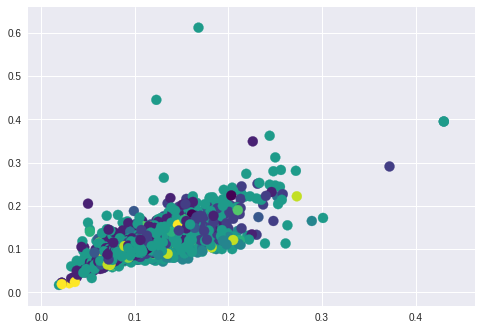

In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=12, covariance_type='full').fit(class_3_sfs)
labels = gmm.predict(class_3_sfs)
probs = gmm.predict_proba(class_3_sfs)
size = 100 * probs.max(1) ** 2
plt.scatter(class_3_sfs['tt4'], class_3_sfs['fti'], c=labels, cmap='viridis', s=size);


We can see there are 5 clusters within the majority class

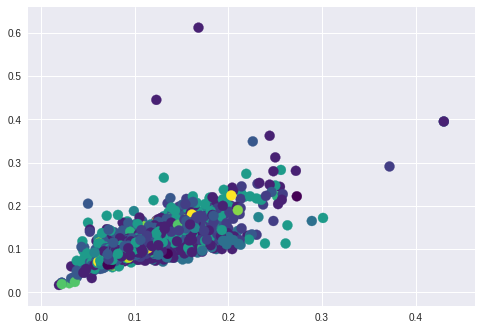

In [ ]:
# Plot the data with K Means to check if we get the same number of clusters we obtained with Gaussian Mixture
from sklearn.cluster import KMeans
kmeans = KMeans(12, random_state=0)
labels = kmeans.fit(class_3_sfs).predict(class_3_sfs)
plt.scatter(class_3_sfs['tt4'], class_3_sfs['fti'], c=labels, s=100, cmap='viridis');

We found 5 clusters, same as GMM

In [ ]:
# This was just to test if the size of the kmeans clusters were similar to the ones found by Gaussian Mixture model.
# Below is the distribution, very close to soft clusters.
'''
Examples within cluster 1:  373
Examples within cluster 2:  1949
Examples within cluster 3:  957
Examples within cluster 4:  126
Examples within cluster 5:  83
'''

'''kmeans = KMeans(5, random_state=0)
labels = kmeans.fit(class_3_sfs).predict(class_3_sfs)

majority_cluster_1_sfs = []
majority_cluster_2_sfs = []
majority_cluster_3_sfs = []
majority_cluster_4_sfs = []
majority_cluster_5_sfs = []

for i in range(0,class_3_sfs.shape[0]):
  if kmeans.labels_[i] == 0:
    majority_cluster_1_sfs.append(class_3_sfs.iloc[i])
  elif kmeans.labels_[i] == 1:
    majority_cluster_2_sfs.append(class_3_sfs.iloc[i])
  elif kmeans.labels_[i] == 2:
    majority_cluster_3_sfs.append(class_3_sfs.iloc[i])
  elif kmeans.labels_[i] == 3:
    majority_cluster_4_sfs.append(class_3_sfs.iloc[i])
  elif kmeans.labels_[i] == 4:
    majority_cluster_5_sfs.append(class_3_sfs.iloc[i])
    
majority_cluster_1_sfs = np.array(majority_cluster_1_sfs)
majority_cluster_2_sfs = np.array(majority_cluster_2_sfs)
majority_cluster_3_sfs = np.array(majority_cluster_3_sfs)
majority_cluster_4_sfs = np.array(majority_cluster_4_sfs)
majority_cluster_5_sfs = np.array(majority_cluster_5_sfs)
print("Examples within cluster 1: ", majority_cluster_1_sfs.shape[0])
print("Examples within cluster 2: ", majority_cluster_2_sfs.shape[0])
print("Examples within cluster 3: ", majority_cluster_3_sfs.shape[0])
print("Examples within cluster 4: ", majority_cluster_4_sfs.shape[0])
print("Examples within cluster 5: ", majority_cluster_5_sfs.shape[0])
print("TOTAL: ", (majority_cluster_1_sfs.shape[0] + majority_cluster_2_sfs.shape[0] + majority_cluster_3_sfs.shape[0] +
                 majority_cluster_4_sfs.shape[0] + majority_cluster_5_sfs.shape[0]))'''

Examples within cluster 1:  373
Examples within cluster 2:  1949
Examples within cluster 3:  957
Examples within cluster 4:  126
Examples within cluster 5:  83
TOTAL:  3488


We can see that there are clearly 5 clusters within the majority class, the same as given by Gaussian Mixture model

We then separate the data according to the 5 clusters found within the majority class

In [ ]:
# Separate examples per cluster of Gaussian Mixture model
gmm = GaussianMixture(n_components=5).fit(class_3_sfs)
probs = gmm.predict_proba(class_3_sfs)

majority_cluster_1_sfs = []
majority_cluster_2_sfs = []
majority_cluster_3_sfs = []
majority_cluster_4_sfs = []
majority_cluster_5_sfs = []

# Assign example to a cluster if the probability of belonging to that cluster is greater than 50%
for i in range(0, probs.shape[0]):
  if probs[i][0] > 0.5:
    majority_cluster_1_sfs.append(class_3_sfs.iloc[i])
  elif probs[i][1] > 0.5:
    majority_cluster_2_sfs.append(class_3_sfs.iloc[i])
  elif probs[i][2] > 0.5:
    majority_cluster_3_sfs.append(class_3_sfs.iloc[i])
  elif probs[i][3] > 0.5:
    majority_cluster_4_sfs.append(class_3_sfs.iloc[i])
  elif probs[i][4] > 0.5:
    majority_cluster_5_sfs.append(class_3_sfs.iloc[i])

majority_cluster_1_sfs = np.array(majority_cluster_1_sfs)
majority_cluster_2_sfs = np.array(majority_cluster_2_sfs)
majority_cluster_3_sfs = np.array(majority_cluster_3_sfs)
majority_cluster_4_sfs = np.array(majority_cluster_4_sfs)
majority_cluster_5_sfs = np.array(majority_cluster_5_sfs)
print("Examples within cluster 1: ", majority_cluster_1_sfs.shape[0])
print("Examples within cluster 2: ", majority_cluster_2_sfs.shape[0])
print("Examples within cluster 3: ", majority_cluster_3_sfs.shape[0])
print("Examples within cluster 4: ", majority_cluster_4_sfs.shape[0])
print("Examples within cluster 5: ", majority_cluster_5_sfs.shape[0])
print("TOTAL: ", (majority_cluster_1_sfs.shape[0] + majority_cluster_2_sfs.shape[0] + majority_cluster_3_sfs.shape[0] +
                 majority_cluster_4_sfs.shape[0] + majority_cluster_5_sfs.shape[0]))

Examples within cluster 1:  1901
Examples within cluster 2:  945
Examples within cluster 3:  456
Examples within cluster 4:  135
Examples within cluster 5:  51
TOTAL:  3488


From the total of 3,488 examples from class 3, we have to undersampling to 1257 (media). 
We will choose the examples withing each of the 5 clusters found randomly and proportional to the size of each cluster.

- for cluster 1: 
  370/3488 * 1257 = 133 
- for cluster 2:
  2005/3488 * 1257 = 722
- for cluster 3:
  990/3488 * 1257 = 356
- for cluster 4:
  82/3488 * 1257 = 29 
- for cluster 5:
  41/3488 * 1257 = 14

In [ ]:
size_cluster_1_sfs = int((majority_cluster_1_sfs.shape[0]/class_3_sfs.shape[0]) * m)
size_cluster_2_sfs = int((majority_cluster_2_sfs.shape[0]/class_3_sfs.shape[0]) * m)
size_cluster_3_sfs = int((majority_cluster_3_sfs.shape[0]/class_3_sfs.shape[0]) * m)
size_cluster_4_sfs = int((majority_cluster_4_sfs.shape[0]/class_3_sfs.shape[0]) * m)
size_cluster_5_sfs = int((majority_cluster_5_sfs.shape[0]/class_3_sfs.shape[0]) * m)
print("Size of cluster 1: ", size_cluster_1_sfs)
print("Size of cluster 2: ", size_cluster_2_sfs)
print("Size of cluster 3: ", size_cluster_3_sfs)
print("Size of cluster 4: ", size_cluster_4_sfs)
print("Size of cluster 5: ", size_cluster_5_sfs)
print("Total: ", (size_cluster_1_sfs + size_cluster_2_sfs + size_cluster_3_sfs + size_cluster_4_sfs + size_cluster_5_sfs))

Size of cluster 1:  685
Size of cluster 2:  340
Size of cluster 3:  164
Size of cluster 4:  48
Size of cluster 5:  18
Total:  1255


In [ ]:
# Proportionally random undersampling from each cluster withing majority class
majority_cluster_1_sfs_us = majority_cluster_1_sfs[np.random.choice(majority_cluster_1_sfs.shape[0], size_cluster_1_sfs)]
majority_cluster_2_sfs_us = majority_cluster_2_sfs[np.random.choice(majority_cluster_2_sfs.shape[0], size_cluster_2_sfs)]
majority_cluster_3_sfs_us = majority_cluster_3_sfs[np.random.choice(majority_cluster_3_sfs.shape[0], size_cluster_3_sfs)]
majority_cluster_4_sfs_us = majority_cluster_4_sfs[np.random.choice(majority_cluster_4_sfs.shape[0], size_cluster_4_sfs)]
majority_cluster_5_sfs_us = majority_cluster_5_sfs[np.random.choice(majority_cluster_5_sfs.shape[0], size_cluster_5_sfs)]

In [ ]:
# Group all clusters from within majority class into singe array

X_majority_resampled_sfs = np.concatenate((majority_cluster_1_sfs_us, majority_cluster_2_sfs_us, majority_cluster_3_sfs_us, 
                                           majority_cluster_4_sfs_us, majority_cluster_5_sfs_us))
print(X_majority_resampled_sfs.shape)

# Create corresponding label array
y_majority_resampled_sfs = np.full((1255,), 3)

(1255, 12)


Now that we have oversampled minority classes and undersampling majority class, we merge the subsets into one new balanced dataset

In [ ]:
# Merge minority and majority class subsets

X_train_scut_sfs = np.append(X_minority_resampled_sfs, X_majority_resampled_sfs, axis=0)
y_train_scut_sfs = np.append(y_minority_resampled_sfs, y_majority_resampled_sfs, axis=0)
print(X_train_scut_sfs.shape)
print(y_train_scut_sfs.shape)

(3769, 12)
(3769,)


In [ ]:
# Checking class balance

pd.Series(y_train_scut_sfs).value_counts()

1.0    1257
2.0    1257
3.0    1255
dtype: int64

###Using all attributes FULL

In [ ]:
# Splitting training set into majority and minority class

y_train_full = y_train.to_frame()
ix = (y_train.loc[y_train_full['class'] == 1]).index.values
class_1_full = X_train.loc[ix,:]
ix = (y_train.loc[y_train_full['class'] == 2]).index.values
class_2_full = X_train.loc[ix,:]
ix = (y_train.loc[y_train_full['class'] == 3]).index.values
class_3_full = X_train.loc[ix,:]

print("class 1: ", class_1_full.shape[0])
print("class 2: ", class_2_full.shape[0])
print("class 3: ", class_3_full.shape[0])
print("Total: ", (class_1_full.shape[0] + class_2_full.shape[0] + class_3_full.shape[0]))

class 1:  93
class 2:  191
class 3:  3488
Total:  3772


In [ ]:
# Calculating media from classes
m = int((class_1_full.shape[0] + class_2_full.shape[0] + class_3_full.shape[0]) / 3)
print("Media: ", m)

Media:  1257


We see that the class 1 and class 2 are under the media, so we will apply SMOTE for their subsets. Class 3 is over the media, so we will apply clustering and undersampling

We apply SMOTE for minority classes

In [ ]:
# group minority clases for SMOTE
minority_classes_full = np.append(X_train, np.expand_dims(y_train, axis=1), axis=1)
minority_classes_full = minority_classes_full[minority_classes_full[:, -1]!=3]

#subset into x,y
minority_x_full = minority_classes_full[:, :-1]
minority_y_full = minority_classes_full[:, -1]

In [ ]:
#applying SMOTE to minority classes
sm = SMOTE(random_state=42, sampling_strategy={2:m, 1:m})
X_minority_resampled_full, y_minority_resampled_full = sm.fit_sample(minority_x_full, minority_y_full)

print('Original dataset shape:', Counter(y_train))
print('Resampled dataset shape:', Counter(y_minority_resampled_full))

Original dataset shape: Counter({3: 3488, 2: 191, 1: 93})
Resampled dataset shape: Counter({2.0: 1257, 1.0: 1257})


/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (1257) in class 2 will be larger than the number of samples in the majority class (class #2.0 -> 191)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (1257) in class 1 will be larger than the number of samples in the majority class (class #2.0 -> 191)
  n_samples_majority))


We now take care of majority class: 
we first cluster the subset using Gaussian Mixture and EM.   
If no clusters are found, then we random select. If more than one cluster is found, then we random select proportionally to each cluster.

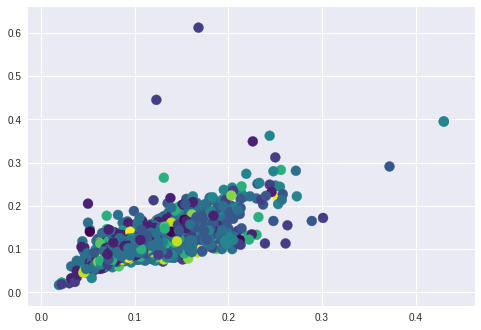

In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=12, covariance_type='full').fit(class_3_full)
labels = gmm.predict(class_3_full)
probs = gmm.predict_proba(class_3_full)
size = 100 * probs.max(1) ** 2
plt.scatter(class_3_full['tt4'], class_3_full['fti'], c=labels, cmap='viridis', s=size);


We can see there are 5 clusters within the majority class

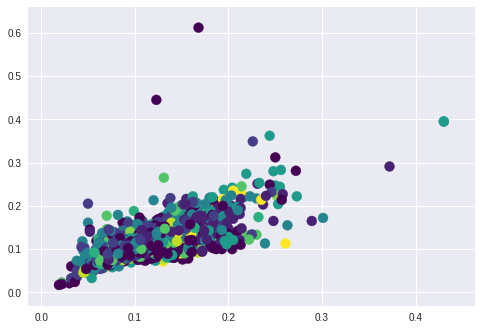

In [ ]:
# Plot the data with K Means to check if we get the same number of clusters we obtained with Gaussian Mixture
from sklearn.cluster import KMeans
kmeans = KMeans(12, random_state=0)
labels = kmeans.fit(class_3_full).predict(class_3_full)
plt.scatter(class_3_full['tt4'], class_3_full['fti'], c=labels, s=100, cmap='viridis');

We found 5 clusters, same as GMM

In [ ]:
# This was just to test if the size of the kmeans clusters were similar to the ones found by Gaussian Mixture model.
# Below is the distribution, very close to soft clusters.
'''
Examples within cluster 1:  1788
Examples within cluster 2:  435
Examples within cluster 3:  873
Examples within cluster 4:  175
Examples within cluster 5:  217
'''

'''kmeans = KMeans(5, random_state=0)
labels = kmeans.fit(class_3_full).predict(class_3_full)

majority_cluster_1_full = []
majority_cluster_2_full = []
majority_cluster_3_full = []
majority_cluster_4_full = []
majority_cluster_5_full = []

for i in range(0,class_3_full.shape[0]):
  if kmeans.labels_[i] == 0:
    majority_cluster_1_full.append(class_3_full.iloc[i])
  elif kmeans.labels_[i] == 1:
    majority_cluster_2_full.append(class_3_full.iloc[i])
  elif kmeans.labels_[i] == 2:
    majority_cluster_3_full.append(class_3_full.iloc[i])
  elif kmeans.labels_[i] == 3:
    majority_cluster_4_full.append(class_3_full.iloc[i])
  elif kmeans.labels_[i] == 4:
    majority_cluster_5_full.append(class_3_full.iloc[i])
    
majority_cluster_1_full = np.array(majority_cluster_1_full)
majority_cluster_2_full = np.array(majority_cluster_2_full)
majority_cluster_3_full = np.array(majority_cluster_3_full)
majority_cluster_4_full = np.array(majority_cluster_4_full)
majority_cluster_5_full = np.array(majority_cluster_5_full)
print("Examples within cluster 1: ", majority_cluster_1_full.shape[0])
print("Examples within cluster 2: ", majority_cluster_2_full.shape[0])
print("Examples within cluster 3: ", majority_cluster_3_full.shape[0])
print("Examples within cluster 4: ", majority_cluster_4_full.shape[0])
print("Examples within cluster 5: ", majority_cluster_5_full.shape[0])
print("TOTAL: ", (majority_cluster_1_full.shape[0] + majority_cluster_2_full.shape[0] + majority_cluster_3_full.shape[0] +
                 majority_cluster_4_full.shape[0] + majority_cluster_5_full.shape[0]))'''

Examples within cluster 1:  1788
Examples within cluster 2:  435
Examples within cluster 3:  873
Examples within cluster 4:  175
Examples within cluster 5:  217
TOTAL:  3488


We can see that there are clearly 5 clusters within the majority class, the same as given by Gaussian Mixture model

We then separate the data according to the 5 clusters found within the majority class

In [ ]:
# Separate examples per cluster of Gaussian Mixture model
gmm = GaussianMixture(n_components=5).fit(class_3_full)
probs = gmm.predict_proba(class_3_full)

majority_cluster_1_full = []
majority_cluster_2_full = []
majority_cluster_3_full = []
majority_cluster_4_full = []
majority_cluster_5_full = []

# Assign example to a cluster if the probability of belonging to that cluster is greater than 50%
for i in range(0, probs.shape[0]):
  if probs[i][0] > 0.5:
    majority_cluster_1_full.append(class_3_full.iloc[i])
  elif probs[i][1] > 0.5:
    majority_cluster_2_full.append(class_3_full.iloc[i])
  elif probs[i][2] > 0.5:
    majority_cluster_3_full.append(class_3_full.iloc[i])
  elif probs[i][3] > 0.5:
    majority_cluster_4_full.append(class_3_full.iloc[i])
  elif probs[i][4] > 0.5:
    majority_cluster_5_full.append(class_3_full.iloc[i])

majority_cluster_1_full = np.array(majority_cluster_1_full)
majority_cluster_2_full = np.array(majority_cluster_2_full)
majority_cluster_3_full = np.array(majority_cluster_3_full)
majority_cluster_4_full = np.array(majority_cluster_4_full)
majority_cluster_5_full = np.array(majority_cluster_5_full)
print("Examples within cluster 1: ", majority_cluster_1_full.shape[0])
print("Examples within cluster 2: ", majority_cluster_2_full.shape[0])
print("Examples within cluster 3: ", majority_cluster_3_full.shape[0])
print("Examples within cluster 4: ", majority_cluster_4_full.shape[0])
print("Examples within cluster 5: ", majority_cluster_5_full.shape[0])
print("TOTAL: ", (majority_cluster_1_full.shape[0] + majority_cluster_2_full.shape[0] + majority_cluster_3_full.shape[0] +
                 majority_cluster_4_full.shape[0] + majority_cluster_5_full.shape[0]))

Examples within cluster 1:  179
Examples within cluster 2:  961
Examples within cluster 3:  217
Examples within cluster 4:  434
Examples within cluster 5:  1697
TOTAL:  3488


From the total of 3,488 examples from class 3, we have to undersampling to 1257 (media). 
We will choose the examples withing each of the 5 clusters found randomly and proportional to the size of each cluster.

- for cluster 1: 
  179/3488 * 1257 = 64 
- for cluster 2:
  961/3488 * 1257 = 346
- for cluster 3:
  217/3488 * 1257 = 78
- for cluster 4:
  434/3488 * 1257 = 156 
- for cluster 5:
  1697/3488 * 1257 = 611

In [ ]:
size_cluster_1_full = int((majority_cluster_1_full.shape[0]/class_3_full.shape[0]) * m)
size_cluster_2_full = int((majority_cluster_2_full.shape[0]/class_3_full.shape[0]) * m)
size_cluster_3_full = int((majority_cluster_3_full.shape[0]/class_3_full.shape[0]) * m)
size_cluster_4_full = int((majority_cluster_4_full.shape[0]/class_3_full.shape[0]) * m)
size_cluster_5_full = int((majority_cluster_5_full.shape[0]/class_3_full.shape[0]) * m)
print("Size of cluster 1: ", size_cluster_1_full)
print("Size of cluster 2: ", size_cluster_2_full)
print("Size of cluster 3: ", size_cluster_3_full)
print("Size of cluster 4: ", size_cluster_4_full)
print("Size of cluster 5: ", size_cluster_5_full)
print("Total: ", (size_cluster_1_full + size_cluster_2_full + size_cluster_3_full + size_cluster_4_full + size_cluster_5_full))

Size of cluster 1:  64
Size of cluster 2:  346
Size of cluster 3:  78
Size of cluster 4:  156
Size of cluster 5:  611
Total:  1255


In [ ]:
# Proportionally random undersampling from each cluster withing majority class
majority_cluster_1_full_us = majority_cluster_1_full[np.random.choice(majority_cluster_1_full.shape[0], size_cluster_1_full)]
majority_cluster_2_full_us = majority_cluster_2_full[np.random.choice(majority_cluster_2_full.shape[0], size_cluster_2_full)]
majority_cluster_3_full_us = majority_cluster_3_full[np.random.choice(majority_cluster_3_full.shape[0], size_cluster_3_full)]
majority_cluster_4_full_us = majority_cluster_4_full[np.random.choice(majority_cluster_4_full.shape[0], size_cluster_4_full)]
majority_cluster_5_full_us = majority_cluster_5_full[np.random.choice(majority_cluster_5_full.shape[0], size_cluster_5_full)]

In [ ]:
# Group all clusters from within majority class into singe array

X_majority_resampled_full = np.concatenate((majority_cluster_1_full_us, majority_cluster_2_full_us, majority_cluster_3_full_us, 
                                           majority_cluster_4_full_us, majority_cluster_5_full_us))
print(X_majority_resampled_full.shape)

# Create corresponding label array
y_majority_resampled_full = np.full((1255,), 3)

(1255, 21)


Now that we have oversampled minority classes and undersampling majority class, we merge the subsets into one new balanced dataset

In [ ]:
# Merge minority and majority class subsets

X_train_scut_full = np.append(X_minority_resampled_full, X_majority_resampled_full, axis=0)
y_train_scut_full = np.append(y_minority_resampled_full, y_majority_resampled_full, axis=0)
print(X_train_scut_full.shape)
print(y_train_scut_full.shape)

(3769, 21)
(3769,)


In [ ]:
# Checking class balance

pd.Series(y_train_scut_full).value_counts()

1.0    1257
2.0    1257
3.0    1255
dtype: int64

# Apply algorithms

# Over Sampling

## Over Sampling PCA

### Desicion Tree Classifier  -  Accuracy: 0.892

              precision    recall  f1-score   support

           1       0.52      0.59      0.55        73
           2       0.08      0.07      0.08       177
           3       0.94      0.94      0.94      3178

   micro avg       0.89      0.89      0.89      3428
   macro avg       0.52      0.54      0.53      3428
weighted avg       0.89      0.89      0.89      3428



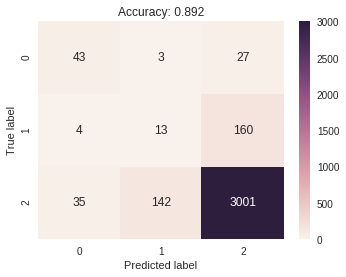

In [ ]:
#decision tree classifier
from sklearn.tree import DecisionTreeClassifier  
dt_cls = DecisionTreeClassifier(random_state=42) 
dt_cls.fit(X_train_oversampling_pca, y_train_oversampling_pca) 
y_pred = dt_cls.predict(X_test_pca)
#confusion matrix
print(classification_report(y_test, y_pred))   
confusion_matrix_heatmap(y_test, y_pred)

### Random Forest Classifier  -  Accuracy: 0.911

              precision    recall  f1-score   support

           1       0.53      0.60      0.56        73
           2       0.17      0.09      0.12       177
           3       0.94      0.96      0.95      3178

   micro avg       0.91      0.91      0.91      3428
   macro avg       0.55      0.55      0.54      3428
weighted avg       0.89      0.91      0.90      3428



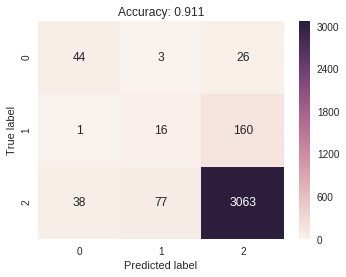

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_cls = RandomForestClassifier(n_estimators=25, random_state=42)
rf_cls.fit(X_train_oversampling_pca, y_train_oversampling_pca)
y_pred = rf_cls.predict(X_test_pca)
#confusion matrix
print(classification_report(y_test, y_pred))   
confusion_matrix_heatmap(y_test, y_pred)

### KNN Classifier   -  Accuracy: 0.808 
Recall: 0.15 lowest    
Precision: 0.08 lowest


              precision    recall  f1-score   support

           1       0.13      0.15      0.14        73
           2       0.08      0.19      0.11       177
           3       0.94      0.86      0.90      3178

   micro avg       0.81      0.81      0.81      3428
   macro avg       0.38      0.40      0.38      3428
weighted avg       0.88      0.81      0.84      3428



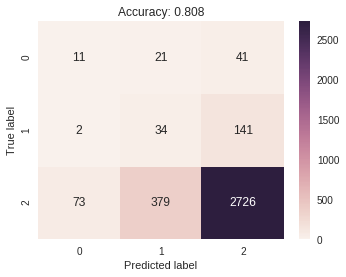

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
kn_cls = KNeighborsClassifier()
kn_cls.fit(X_train_oversampling_pca, y_train_oversampling_pca)
y_pred = kn_cls.predict(X_test_pca)
#confusion matrix 
print(classification_report(y_test, y_pred))  
confusion_matrix_heatmap(y_test, y_pred)

### SVM Classifier Kernel Linear  -  Accuracy: 0.434
Precision 0.02 lowest   
F-score 0.04 lowest

              precision    recall  f1-score   support

           1       0.02      0.45      0.04        73
           2       0.07      0.23      0.11       177
           3       0.96      0.44      0.61      3178

   micro avg       0.43      0.43      0.43      3428
   macro avg       0.35      0.37      0.25      3428
weighted avg       0.89      0.43      0.57      3428



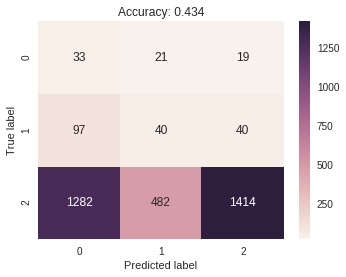

In [ ]:
#SVM
from sklearn.svm import SVC
svm_cls = SVC(kernel='linear')
y_pred = svm_cls.fit(X_train_oversampling_pca, y_train_oversampling_pca)
y_pred = svm_cls.predict(X_test_pca)
#confusion matrix 
print(classification_report(y_test, y_pred))  
confusion_matrix_heatmap(y_test, y_pred)

## Over Sampling SFS

### Desicion Tree Classifier  -  Accuracy: 0.991

              precision    recall  f1-score   support

           1       0.85      0.88      0.86        73
           2       0.94      0.99      0.97       177
           3       1.00      0.99      0.99      3178

   micro avg       0.99      0.99      0.99      3428
   macro avg       0.93      0.95      0.94      3428
weighted avg       0.99      0.99      0.99      3428



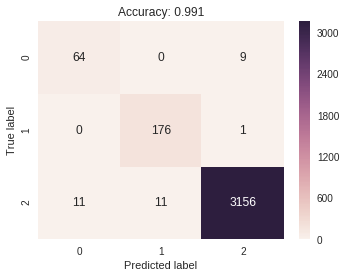

In [ ]:
#decision tree classifier
from sklearn.tree import DecisionTreeClassifier  
dt_cls = DecisionTreeClassifier(random_state=42) 
dt_cls.fit(X_train_oversampling_sfs, y_train_oversampling_sfs) 
y_pred = dt_cls.predict(X_test_sfs)
#confusion matrix
print(classification_report(y_test, y_pred))   
confusion_matrix_heatmap(y_test, y_pred)

### Random Forest Classifier  -  Accuracy: 0.993

              precision    recall  f1-score   support

           1       0.86      0.96      0.91        73
           2       0.94      1.00      0.97       177
           3       1.00      0.99      1.00      3178

   micro avg       0.99      0.99      0.99      3428
   macro avg       0.93      0.98      0.96      3428
weighted avg       0.99      0.99      0.99      3428



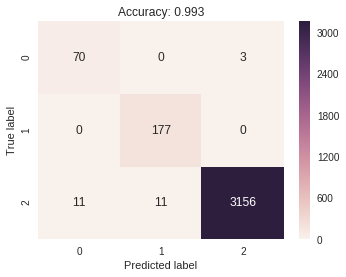

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_cls = RandomForestClassifier(n_estimators=25, random_state=42)
rf_cls.fit(X_train_oversampling_sfs, y_train_oversampling_sfs)
y_pred = rf_cls.predict(X_test_sfs)
#confusion matrix
print(classification_report(y_test, y_pred))   
confusion_matrix_heatmap(y_test, y_pred)

### KNN Classifier   -  Accuracy: 0.890 
Recall: 0.39 lowest    
Precision: 0.26 lowest


              precision    recall  f1-score   support

           1       0.54      0.62      0.57        73
           2       0.24      0.39      0.30       177
           3       0.96      0.92      0.94      3178

   micro avg       0.89      0.89      0.89      3428
   macro avg       0.58      0.64      0.60      3428
weighted avg       0.91      0.89      0.90      3428



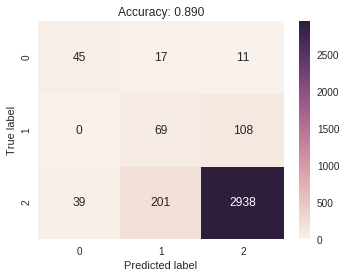

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
kn_cls = KNeighborsClassifier()
kn_cls.fit(X_train_oversampling_sfs, y_train_oversampling_sfs)
y_pred = kn_cls.predict(X_test_sfs)
#confusion matrix 
print(classification_report(y_test, y_pred))  
confusion_matrix_heatmap(y_test, y_pred)

### SVM Classifier Kernel Linear  -  Accuracy: 0.688
Precision 0.11 lowest   
F-score 0.20 lowest

              precision    recall  f1-score   support

           1       0.52      0.93      0.67        73
           2       0.11      0.69      0.20       177
           3       0.98      0.68      0.80      3178

   micro avg       0.69      0.69      0.69      3428
   macro avg       0.54      0.77      0.56      3428
weighted avg       0.92      0.69      0.77      3428



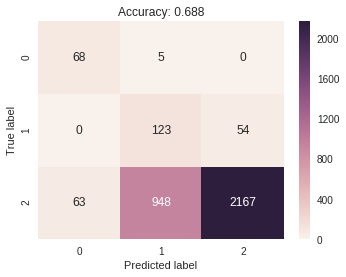

In [ ]:
#SVM
from sklearn.svm import SVC
svm_cls = SVC(kernel='linear')
y_pred = svm_cls.fit(X_train_oversampling_sfs, y_train_oversampling_sfs)
y_pred = svm_cls.predict(X_test_sfs)
#confusion matrix 
print(classification_report(y_test, y_pred))  
confusion_matrix_heatmap(y_test, y_pred)

## Over Sampling FULL

### Desicion Tree Classifier  -  Accuracy: 0.992

              precision    recall  f1-score   support

           1       0.90      0.88      0.89        73
           2       0.95      0.99      0.97       177
           3       1.00      0.99      1.00      3178

   micro avg       0.99      0.99      0.99      3428
   macro avg       0.95      0.96      0.95      3428
weighted avg       0.99      0.99      0.99      3428



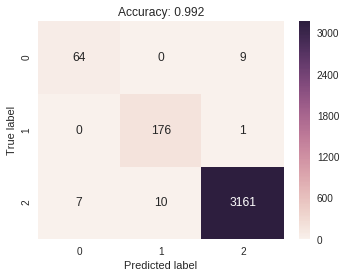

In [ ]:
#decision tree classifier
from sklearn.tree import DecisionTreeClassifier  
dt_cls = DecisionTreeClassifier(random_state=42) 
dt_cls.fit(X_train_oversampling_full, y_train_oversampling_full) 
y_pred = dt_cls.predict(X_test)
#confusion matrix
print(classification_report(y_test, y_pred))   
confusion_matrix_heatmap(y_test, y_pred)

### Random Forest Classifier  -  Accuracy: 0.992

              precision    recall  f1-score   support

           1       0.87      1.00      0.93        73
           2       0.92      1.00      0.96       177
           3       1.00      0.99      1.00      3178

   micro avg       0.99      0.99      0.99      3428
   macro avg       0.93      1.00      0.96      3428
weighted avg       0.99      0.99      0.99      3428



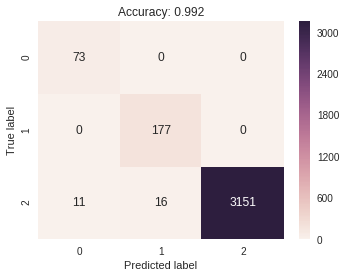

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_cls = RandomForestClassifier(n_estimators=25, random_state=42)
rf_cls.fit(X_train_oversampling_full, y_train_oversampling_full)
y_pred = rf_cls.predict(X_test)
#confusion matrix
print(classification_report(y_test, y_pred))   
confusion_matrix_heatmap(y_test, y_pred)

### KNN Classifier   -  Accuracy: 0.871 
Recall: 0.30 lowest    
Precision: 0.16 lowest


              precision    recall  f1-score   support

           1       0.57      0.55      0.56        73
           2       0.16      0.30      0.21       177
           3       0.96      0.91      0.93      3178

   micro avg       0.87      0.87      0.87      3428
   macro avg       0.56      0.59      0.57      3428
weighted avg       0.91      0.87      0.89      3428



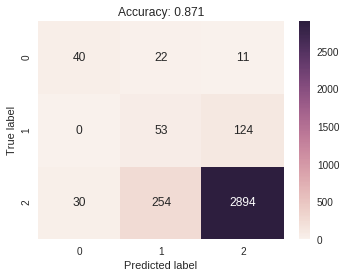

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
kn_cls = KNeighborsClassifier()
kn_cls.fit(X_train_oversampling_full, y_train_oversampling_full)
y_pred = kn_cls.predict(X_test)
#confusion matrix 
print(classification_report(y_test, y_pred))  
confusion_matrix_heatmap(y_test, y_pred)

### SVM Classifier Kernel Linear  -  Accuracy: 0.723
Precision 0.12 lowest   
F-score 0.21 lowest

              precision    recall  f1-score   support

           1       0.54      0.90      0.68        73
           2       0.12      0.67      0.21       177
           3       0.98      0.72      0.83      3178

   micro avg       0.72      0.72      0.72      3428
   macro avg       0.55      0.77      0.57      3428
weighted avg       0.92      0.72      0.79      3428



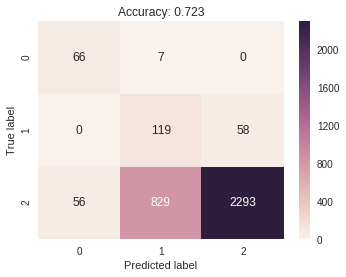

In [ ]:
#SVM
from sklearn.svm import SVC
svm_cls = SVC(kernel='linear')
y_pred = svm_cls.fit(X_train_oversampling_full, y_train_oversampling_full)
y_pred = svm_cls.predict(X_test)
#confusion matrix 
print(classification_report(y_test, y_pred))  
confusion_matrix_heatmap(y_test, y_pred)

# SMOTE

## SMOTE PCA

### Desicion Tree Classifier  -  Accuracy: 0.798

              precision    recall  f1-score   support

           1       0.41      0.67      0.51        73
           2       0.11      0.33      0.16       177
           3       0.95      0.83      0.88      3178

   micro avg       0.80      0.80      0.80      3428
   macro avg       0.49      0.61      0.52      3428
weighted avg       0.90      0.80      0.84      3428



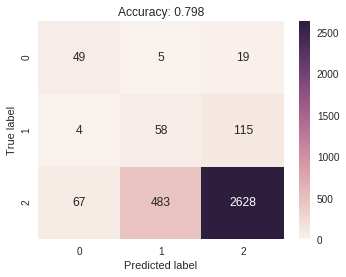

In [ ]:
#decision tree classifier
from sklearn.tree import DecisionTreeClassifier  
dt_cls = DecisionTreeClassifier(random_state=42) 
dt_cls.fit(X_train_smote_pca, y_train_smote_pca) 
y_pred = dt_cls.predict(X_test_pca)
#confusion matrix
print(classification_report(y_test, y_pred))   
confusion_matrix_heatmap(y_test, y_pred)

### Random Forest Classifier  -  Accuracy: 0.824

              precision    recall  f1-score   support

           1       0.41      0.68      0.51        73
           2       0.12      0.29      0.17       177
           3       0.95      0.86      0.90      3178

   micro avg       0.82      0.82      0.82      3428
   macro avg       0.49      0.61      0.53      3428
weighted avg       0.90      0.82      0.86      3428



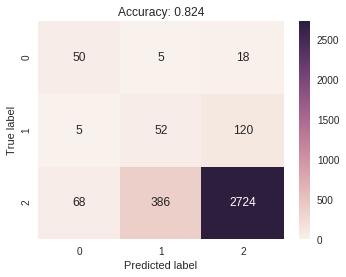

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_cls = RandomForestClassifier(n_estimators=25, random_state=42)
rf_cls.fit(X_train_smote_pca, y_train_smote_pca)
y_pred = rf_cls.predict(X_test_pca)
#confusion matrix
print(classification_report(y_test, y_pred))   
confusion_matrix_heatmap(y_test, y_pred)

### KNN Classifier   -  Accuracy: 0.777 
Recall: 0.25 lowest    
Precision: 0.08 lowest


              precision    recall  f1-score   support

           1       0.27      0.59      0.37        73
           2       0.08      0.25      0.12       177
           3       0.95      0.81      0.87      3178

   micro avg       0.78      0.78      0.78      3428
   macro avg       0.43      0.55      0.45      3428
weighted avg       0.89      0.78      0.82      3428



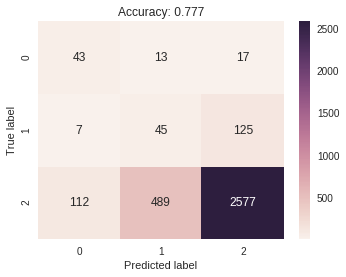

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
kn_cls = KNeighborsClassifier()
kn_cls.fit(X_train_smote_pca, y_train_smote_pca)
y_pred = kn_cls.predict(X_test_pca)
#confusion matrix 
print(classification_report(y_test, y_pred))  
confusion_matrix_heatmap(y_test, y_pred)

### SVM Classifier Kernel Linear  -  Accuracy: 0.237
Precision 0.02 lowest   
F-score 0.04 lowest

              precision    recall  f1-score   support

           1       0.02      0.59      0.04        73
           2       0.07      0.23      0.11       177
           3       0.98      0.23      0.37      3178

   micro avg       0.24      0.24      0.24      3428
   macro avg       0.36      0.35      0.17      3428
weighted avg       0.91      0.24      0.35      3428



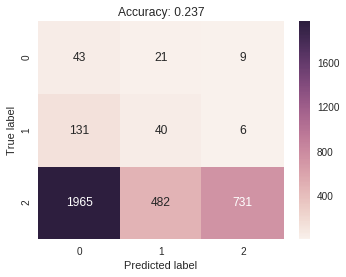

In [ ]:
#SVM
from sklearn.svm import SVC
svm_cls = SVC(kernel='linear')
y_pred = svm_cls.fit(X_train_smote_pca, y_train_smote_pca)
y_pred = svm_cls.predict(X_test_pca)
#confusion matrix 
print(classification_report(y_test, y_pred))  
confusion_matrix_heatmap(y_test, y_pred)

## SMOTE SFS

### Desicion Tree Classifier  -  Accuracy: 0.991

              precision    recall  f1-score   support

           1       0.85      0.88      0.86        73
           2       0.94      1.00      0.97       177
           3       1.00      0.99      1.00      3178

   micro avg       0.99      0.99      0.99      3428
   macro avg       0.93      0.96      0.94      3428
weighted avg       0.99      0.99      0.99      3428



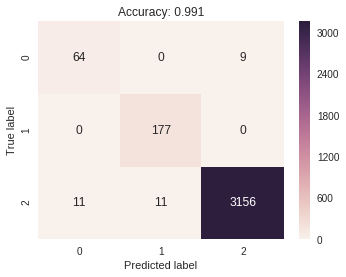

In [ ]:
#decision tree classifier
from sklearn.tree import DecisionTreeClassifier  
dt_cls = DecisionTreeClassifier(random_state=42) 
dt_cls.fit(X_train_smote_sfs, y_train_smote_sfs) 
y_pred = dt_cls.predict(X_test_sfs)
#confusion matrix
print(classification_report(y_test, y_pred))   
confusion_matrix_heatmap(y_test, y_pred)

### Random Forest Classifier  -  Accuracy: 0.992

              precision    recall  f1-score   support

           1       0.86      0.96      0.91        73
           2       0.94      1.00      0.97       177
           3       1.00      0.99      1.00      3178

   micro avg       0.99      0.99      0.99      3428
   macro avg       0.93      0.98      0.96      3428
weighted avg       0.99      0.99      0.99      3428



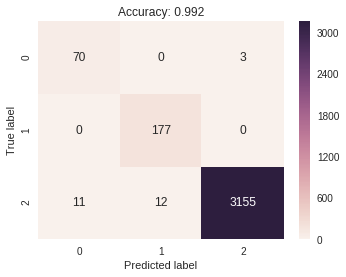

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_cls = RandomForestClassifier(n_estimators=25, random_state=42)
rf_cls.fit(X_train_smote_sfs, y_train_smote_sfs)
y_pred = rf_cls.predict(X_test_sfs)
#confusion matrix
print(classification_report(y_test, y_pred))   
confusion_matrix_heatmap(y_test, y_pred)

### KNN Classifier   -  Accuracy: 0.854 
Recall: 0.47 lowest    
Precision: 0.19 lowest


              precision    recall  f1-score   support

           1       0.53      0.68      0.60        73
           2       0.19      0.47      0.27       177
           3       0.97      0.88      0.92      3178

   micro avg       0.85      0.85      0.85      3428
   macro avg       0.56      0.68      0.59      3428
weighted avg       0.92      0.85      0.88      3428



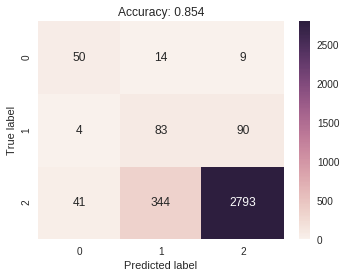

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
kn_cls = KNeighborsClassifier()
kn_cls.fit(X_train_smote_sfs, y_train_smote_sfs)
y_pred = kn_cls.predict(X_test_sfs)
#confusion matrix 
print(classification_report(y_test, y_pred))  
confusion_matrix_heatmap(y_test, y_pred)

### SVM Classifier Kernel Linear  -  Accuracy: 0.702
Precision 0.12 lowest   
F-score 0.20 lowest

              precision    recall  f1-score   support

           1       0.56      0.93      0.70        73
           2       0.12      0.67      0.20       177
           3       0.97      0.70      0.81      3178

   micro avg       0.70      0.70      0.70      3428
   macro avg       0.55      0.77      0.57      3428
weighted avg       0.92      0.70      0.78      3428



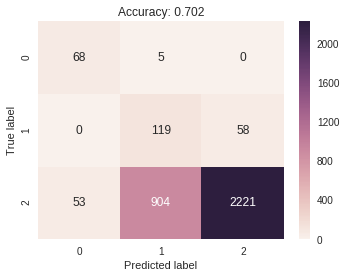

In [ ]:
#SVM
from sklearn.svm import SVC
svm_cls = SVC(kernel='linear')
y_pred = svm_cls.fit(X_train_smote_sfs, y_train_smote_sfs)
y_pred = svm_cls.predict(X_test_sfs)
#confusion matrix 
print(classification_report(y_test, y_pred))  
confusion_matrix_heatmap(y_test, y_pred)

## SMOTE FULL

### Desicion Tree Classifier  -  Accuracy: 0.992

              precision    recall  f1-score   support

           1       0.90      0.86      0.88        73
           2       0.94      1.00      0.97       177
           3       1.00      0.99      1.00      3178

   micro avg       0.99      0.99      0.99      3428
   macro avg       0.95      0.95      0.95      3428
weighted avg       0.99      0.99      0.99      3428



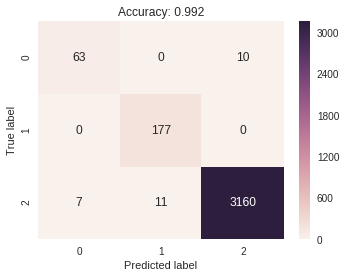

In [ ]:
#decision tree classifier
from sklearn.tree import DecisionTreeClassifier  
dt_cls = DecisionTreeClassifier(random_state=42) 
dt_cls.fit(X_train_smote_full, y_train_smote_full) 
y_pred = dt_cls.predict(X_test)
#confusion matrix
print(classification_report(y_test, y_pred))   
confusion_matrix_heatmap(y_test, y_pred)

### Random Forest Classifier  -  Accuracy: 0.993

              precision    recall  f1-score   support

           1       0.88      1.00      0.94        73
           2       0.93      1.00      0.96       177
           3       1.00      0.99      1.00      3178

   micro avg       0.99      0.99      0.99      3428
   macro avg       0.94      1.00      0.96      3428
weighted avg       0.99      0.99      0.99      3428



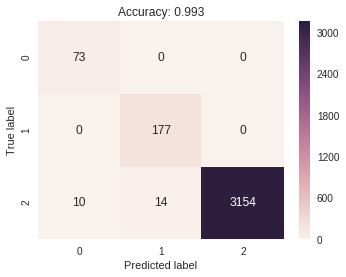

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_cls = RandomForestClassifier(n_estimators=25, random_state=42)
rf_cls.fit(X_train_smote_full, y_train_smote_full)
y_pred = rf_cls.predict(X_test)
#confusion matrix
print(classification_report(y_test, y_pred))   
confusion_matrix_heatmap(y_test, y_pred)

### KNN Classifier   -  Accuracy: 0.823
Recall: 0.44 lowest    
Precision: 0.15 lowest


              precision    recall  f1-score   support

           1       0.51      0.63      0.56        73
           2       0.15      0.44      0.22       177
           3       0.96      0.85      0.90      3178

   micro avg       0.82      0.82      0.82      3428
   macro avg       0.54      0.64      0.56      3428
weighted avg       0.91      0.82      0.86      3428



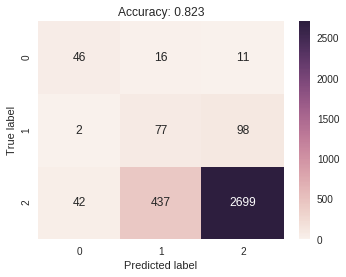

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
kn_cls = KNeighborsClassifier()
kn_cls.fit(X_train_smote_full, y_train_smote_full)
y_pred = kn_cls.predict(X_test)
#confusion matrix 
print(classification_report(y_test, y_pred))  
confusion_matrix_heatmap(y_test, y_pred)

### SVM Classifier Kernel Linear  -  Accuracy: 0.712
Precision 0.12 lowest   
F-score 0.21 lowest

              precision    recall  f1-score   support

           1       0.57      0.89      0.69        73
           2       0.12      0.68      0.21       177
           3       0.98      0.71      0.82      3178

   micro avg       0.71      0.71      0.71      3428
   macro avg       0.55      0.76      0.57      3428
weighted avg       0.92      0.71      0.79      3428



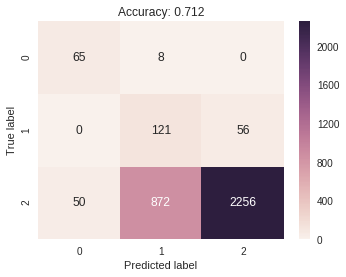

In [ ]:
#SVM
from sklearn.svm import SVC
svm_cls = SVC(kernel='linear')
y_pred = svm_cls.fit(X_train_smote_full, y_train_smote_full)
y_pred = svm_cls.predict(X_test)
#confusion matrix 
print(classification_report(y_test, y_pred))  
confusion_matrix_heatmap(y_test, y_pred)

# SCUT

## SCUT PCA

### Desicion Tree Classifier  -  Accuracy: 0.714

              precision    recall  f1-score   support

           1       0.25      0.63      0.36        73
           2       0.08      0.38      0.14       177
           3       0.95      0.73      0.83      3178

   micro avg       0.71      0.71      0.71      3428
   macro avg       0.43      0.58      0.44      3428
weighted avg       0.89      0.71      0.78      3428



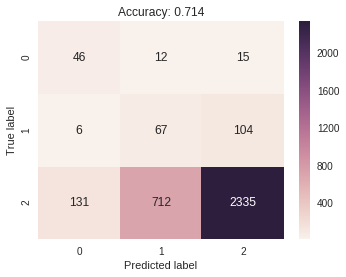

In [ ]:
#decision tree classifier
from sklearn.tree import DecisionTreeClassifier  
dt_cls = DecisionTreeClassifier(random_state=42) 
dt_cls.fit(X_train_scut_pca, y_train_scut_pca) 
y_pred = dt_cls.predict(X_test_pca)
#confusion matrix
print(classification_report(y_test, y_pred))   
confusion_matrix_heatmap(y_test, y_pred)

### Random Forest Classifier  -  Accuracy: 0.745

              precision    recall  f1-score   support

           1       0.35      0.68      0.47        73
           2       0.10      0.41      0.16       177
           3       0.95      0.76      0.85      3178

   micro avg       0.74      0.74      0.74      3428
   macro avg       0.47      0.62      0.49      3428
weighted avg       0.90      0.74      0.81      3428



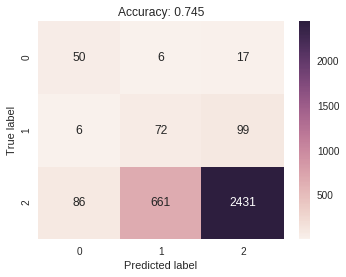

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_cls = RandomForestClassifier(n_estimators=25, random_state=42)
rf_cls.fit(X_train_scut_pca, y_train_scut_pca)
y_pred = rf_cls.predict(X_test_pca)
#confusion matrix
print(classification_report(y_test, y_pred))   
confusion_matrix_heatmap(y_test, y_pred)

### KNN Classifier   -  Accuracy: 0.669 
Recall: 0.33 lowest    
Precision: 0.07 lowest


              precision    recall  f1-score   support

           1       0.11      0.49      0.18        73
           2       0.07      0.33      0.12       177
           3       0.95      0.69      0.80      3178

   micro avg       0.67      0.67      0.67      3428
   macro avg       0.38      0.51      0.37      3428
weighted avg       0.89      0.67      0.75      3428



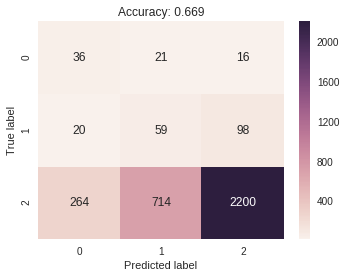

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
kn_cls = KNeighborsClassifier()
kn_cls.fit(X_train_scut_pca, y_train_scut_pca)
y_pred = kn_cls.predict(X_test_pca)
#confusion matrix 
print(classification_report(y_test, y_pred))  
confusion_matrix_heatmap(y_test, y_pred)

### SVM Classifier Kernel Linear  -  Accuracy: 0.266
Precision 0.02 lowest   
F-score 0.03 lowest

              precision    recall  f1-score   support

           1       0.02      0.21      0.03        73
           2       0.07      0.75      0.13       177
           3       0.98      0.24      0.39      3178

   micro avg       0.27      0.27      0.27      3428
   macro avg       0.36      0.40      0.18      3428
weighted avg       0.91      0.27      0.37      3428



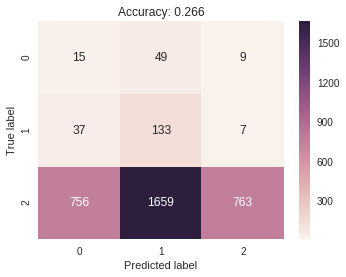

In [ ]:
#SVM
from sklearn.svm import SVC
svm_cls = SVC(kernel='linear')
y_pred = svm_cls.fit(X_train_scut_pca, y_train_scut_pca)
y_pred = svm_cls.predict(X_test_pca)
#confusion matrix 
print(classification_report(y_test, y_pred))  
confusion_matrix_heatmap(y_test, y_pred)

## SCUT SFS

### Desicion Tree Classifier  -  Accuracy: 0.991

              precision    recall  f1-score   support

           1       0.87      0.99      0.92        73
           2       0.90      0.99      0.95       177
           3       1.00      0.99      0.99      3178

   micro avg       0.99      0.99      0.99      3428
   macro avg       0.92      0.99      0.95      3428
weighted avg       0.99      0.99      0.99      3428



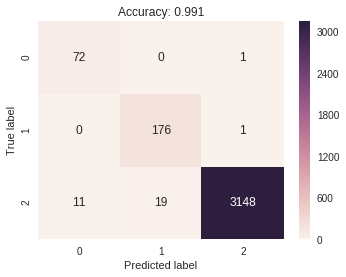

In [ ]:
#decision tree classifier
from sklearn.tree import DecisionTreeClassifier  
dt_cls = DecisionTreeClassifier(random_state=42) 
dt_cls.fit(X_train_scut_sfs, y_train_scut_sfs) 
y_pred = dt_cls.predict(X_test_sfs)
#confusion matrix
print(classification_report(y_test, y_pred))   
confusion_matrix_heatmap(y_test, y_pred)

### Random Forest Classifier  -  Accuracy: 0.989

              precision    recall  f1-score   support

           1       0.87      0.99      0.92        73
           2       0.87      1.00      0.93       177
           3       1.00      0.99      0.99      3178

   micro avg       0.99      0.99      0.99      3428
   macro avg       0.91      0.99      0.95      3428
weighted avg       0.99      0.99      0.99      3428



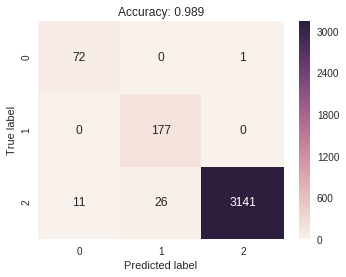

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_cls = RandomForestClassifier(n_estimators=25, random_state=42)
rf_cls.fit(X_train_scut_sfs, y_train_scut_sfs)
y_pred = rf_cls.predict(X_test_sfs)
#confusion matrix
print(classification_report(y_test, y_pred))   
confusion_matrix_heatmap(y_test, y_pred)

### KNN Classifier   -  Accuracy: 0.789 
Recall: 0.51 lowest    
Precision: 0.14 lowest


              precision    recall  f1-score   support

           1       0.40      0.70      0.51        73
           2       0.14      0.51      0.22       177
           3       0.97      0.81      0.88      3178

   micro avg       0.79      0.79      0.79      3428
   macro avg       0.50      0.67      0.54      3428
weighted avg       0.91      0.79      0.84      3428



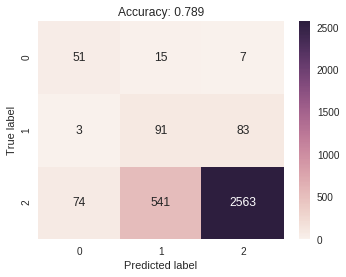

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
kn_cls = KNeighborsClassifier()
kn_cls.fit(X_train_scut_sfs, y_train_scut_sfs)
y_pred = kn_cls.predict(X_test_sfs)
#confusion matrix 
print(classification_report(y_test, y_pred))  
confusion_matrix_heatmap(y_test, y_pred)

### SVM Classifier Kernel Linear  -  Accuracy: 0.554
Precision 0.09 lowest   
F-score 0.16 lowest

              precision    recall  f1-score   support

           1       0.56      0.82      0.66        73
           2       0.09      0.78      0.16       177
           3       0.98      0.53      0.69      3178

   micro avg       0.55      0.55      0.55      3428
   macro avg       0.54      0.71      0.50      3428
weighted avg       0.92      0.55      0.66      3428



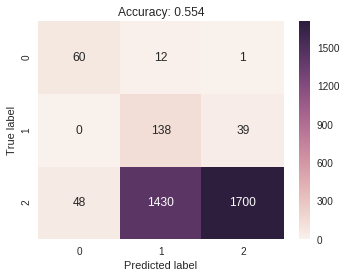

In [ ]:
#SVM
from sklearn.svm import SVC
svm_cls = SVC(kernel='linear')
y_pred = svm_cls.fit(X_train_scut_sfs, y_train_scut_sfs)
y_pred = svm_cls.predict(X_test_sfs)
#confusion matrix 
print(classification_report(y_test, y_pred))  
confusion_matrix_heatmap(y_test, y_pred)

## SCUT FULL

###Desicion Tree Classifier  -  Accuracy: 0.994

              precision    recall  f1-score   support

           1       0.91      0.99      0.95        73
           2       0.94      1.00      0.97       177
           3       1.00      0.99      1.00      3178

   micro avg       0.99      0.99      0.99      3428
   macro avg       0.95      0.99      0.97      3428
weighted avg       0.99      0.99      0.99      3428



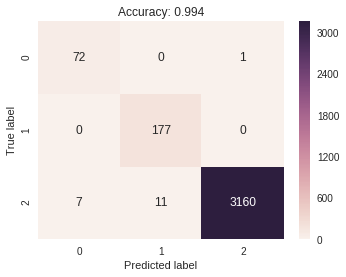

In [ ]:
#decision tree classifier
from sklearn.tree import DecisionTreeClassifier  
dt_cls = DecisionTreeClassifier(random_state=42) 
dt_cls.fit(X_train_scut_full, y_train_scut_full) 
y_pred = dt_cls.predict(X_test)
#confusion matrix
print(classification_report(y_test, y_pred))   
confusion_matrix_heatmap(y_test, y_pred)

### Random Forest Classifier  -  Accuracy: 0.986

              precision    recall  f1-score   support

           1       0.86      1.00      0.92        73
           2       0.83      1.00      0.91       177
           3       1.00      0.99      0.99      3178

   micro avg       0.99      0.99      0.99      3428
   macro avg       0.90      1.00      0.94      3428
weighted avg       0.99      0.99      0.99      3428



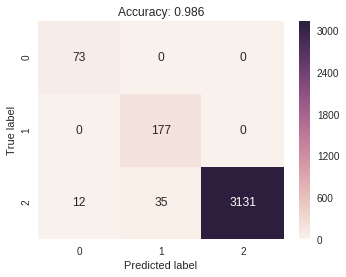

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_cls = RandomForestClassifier(n_estimators=25, random_state=42)
rf_cls.fit(X_train_scut_full, y_train_scut_full)
y_pred = rf_cls.predict(X_test)
#confusion matrix
print(classification_report(y_test, y_pred))   
confusion_matrix_heatmap(y_test, y_pred)

### KNN Classifier   -  Accuracy: 0.746
Recall: 0.47 lowest    
Precision: 0.15 lowest


              precision    recall  f1-score   support

           1       0.45      0.62      0.52        73
           2       0.10      0.47      0.17       177
           3       0.96      0.76      0.85      3178

   micro avg       0.75      0.75      0.75      3428
   macro avg       0.50      0.62      0.51      3428
weighted avg       0.90      0.75      0.81      3428



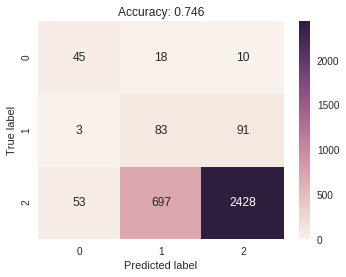

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
kn_cls = KNeighborsClassifier()
kn_cls.fit(X_train_scut_full, y_train_scut_full)
y_pred = kn_cls.predict(X_test)
#confusion matrix 
print(classification_report(y_test, y_pred))  
confusion_matrix_heatmap(y_test, y_pred)

### SVM Classifier Kernel Linear  -  Accuracy: 0.594
Precision 0.09 lowest   
F-score 0.27 lowest

              precision    recall  f1-score   support

           1       0.58      0.84      0.69        73
           2       0.09      0.77      0.17       177
           3       0.98      0.58      0.73      3178

   micro avg       0.59      0.59      0.59      3428
   macro avg       0.55      0.73      0.53      3428
weighted avg       0.92      0.59      0.70      3428



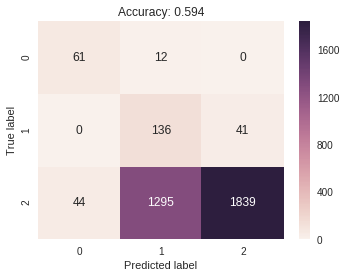

In [ ]:
#SVM
from sklearn.svm import SVC
svm_cls = SVC(kernel='linear')
y_pred = svm_cls.fit(X_train_scut_full, y_train_scut_full)
y_pred = svm_cls.predict(X_test)
#confusion matrix 
print(classification_report(y_test, y_pred))  
confusion_matrix_heatmap(y_test, y_pred)